## Import Packages

In [1]:
from matplotlib import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer, StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error, r2_score
import xgboost as xgb
from Helper_Functions import degree_search
from Helper_Functions import polynomial_search
from Helper_Functions import json_to_series
from joblib import dump, load

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option('display.max_columns', 500)
%matplotlib inline

## Read Training Data

In [2]:
training = pd.read_csv("Data/train.csv")


C:\Users\Edwin\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
training = training.sample(n=200000).reset_index(drop=True)

## Expand Json Columns

In [4]:
json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource', 'adwordsClickInfo']

# training['device'].map(eval, false=False)




for col in json_cols:
    training[col] = training[col].astype(str)
    training[col] = training[col].str.replace('false', 'False').str.replace('true', 'True').map(eval)
    training = pd.concat([training.drop([col], axis=1), training[col].apply(pd.Series)], axis=1)
    
training.head(10)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserVersion,browserSize,operatingSystem,operatingSystemVersion,isMobile,mobileDeviceBranding,mobileDeviceModel,mobileInputSelector,mobileDeviceInfo,mobileDeviceMarketingName,flashVersion,language,screenColors,screenResolution,deviceCategory,continent,subContinent,country,region,metro,city,cityId,networkDomain,latitude,longitude,networkLocation,visits,hits,pageviews,bounces,newVisits,transactionRevenue,referralPath,campaign,source,medium,keyword,isTrueDirect,adContent,campaignCode,criteriaParameters,page,slot,gclId,adNetworkType,isVideoAd,targetingCriteria
0,Social,20161105,7973979000104117684,7973979000104117684_1478393390,Not Socially Engaged,1478393390,1,1478393390,Safari,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Bursa,(not set),Bursa,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,/yt/about/tr/,(not set),youtube.com,referral,NaN,NaN,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20170104,4774469965641663376,4774469965641663376_1483591956,Not Socially Engaged,1483591956,1,1483591956,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,3,3,NaN,1,NaN,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,20170530,9247353407402273644,9247353407402273644_1496128823,Not Socially Engaged,1496128823,1,1496128823,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Eastern Europe,Poland,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,korbank.pl,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,2,2,NaN,1,NaN,NaN,(not set),(direct),(none),NaN,True,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN
3,Direct,20161106,3675635497707905432,3675635497707905432_1478469366,Not Socially Engaged,1478469366,5,1478469366,Safari,not available in demo dataset,not available in demo dataset,iOS,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,tablet,Europe,Northern Europe,Finland,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,elisa-mobile.fi,not available in demo dataset,not available in demo dataset,not available in d

## NA value recognition

In [5]:
for col in training.columns:
    training[col] = training[col].replace('(not set)', np.nan)

## Remove Unavailable Columns

In [6]:
cols_to_drop = [col for col in training.columns if 'not available in demo dataset' in list(training[col])]
print(cols_to_drop)

training = training[[col for col in training.columns if col not in cols_to_drop]]

training.head(10)

['browserVersion', 'browserSize', 'operatingSystemVersion', 'mobileDeviceBranding', 'mobileDeviceModel', 'mobileInputSelector', 'mobileDeviceInfo', 'mobileDeviceMarketingName', 'flashVersion', 'language', 'screenColors', 'screenResolution', 'region', 'metro', 'city', 'cityId', 'latitude', 'longitude', 'networkLocation', 'criteriaParameters']


,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,operatingSystem,isMobile,deviceCategory,continent,subContinent,country,networkDomain,visits,hits,pageviews,bounces,newVisits,transactionRevenue,referralPath,campaign,source,medium,keyword,isTrueDirect,adContent,campaignCode,page,slot,gclId,adNetworkType,isVideoAd,targetingCriteria
0,Social,20161105,7973979000104117684,7973979000104117684_1478393390,Not Socially Engaged,1478393390,1,1478393390,Safari,Macintosh,False,desktop,Asia,Western Asia,Turkey,ttnet.com.tr,1,1,1,1,1,NaN,/yt/about/tr/,NaN,youtube.com,referral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20170104,4774469965641663376,4774469965641663376_1483591956,Not Socially Engaged,1483591956,1,1483591956,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,NaN,1,3,3,NaN,1,NaN,NaN,NaN,google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,20170530,9247353407402273644,9247353407402273644_1496128823,Not Socially Engaged,1496128823,1,1496128823,Chrome,Windows,False,desktop,Europe,Eastern Europe,Poland,korbank.pl,1,2,2,NaN,1,NaN,NaN,NaN,(direct),(none),NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Direct,20161106,3675635497707905432,3675635497707905432_1478469366,Not Socially Engaged,1478469366,5,1478469366,Safari,iOS,True,tablet,Europe,Northern Europe,Finland,elisa-mobile.fi,1,2,2,NaN,NaN,NaN,NaN,NaN,(direct),(none),NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20170728,5212730854379106231,5212730854379106231_1501265538,Not Socially Engaged,1501265538,1,1501265538,Chrome,Android,True,mobile,Americas,Northern America,United States,rr.com,1,3,3,NaN,1,NaN,NaN,NaN,google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Organic Search,20170604,1875200872650366687,1875200872650366687_1496597002,Not Socially Engaged,1496597002,1,1496597002,Chrome,Windows,False,desktop,Asia,Southern Asia,Pakistan,unknown.unknown,1,1,1,1,1,NaN,NaN,NaN,google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Social,20170119,7915361057630832818,7915361057630832818_1484878428,Not Socially Engaged,1484878428,1,1484878428,Chrome,Windows,False,desktop,Asia,Southeast Asia,Thailand,unknown.unknown,1,1,1,1,1,NaN,/yt/about/,NaN,youtube.com,referral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Organic Search,20170115,864619232804442046,0864619232804442046_1484478552,Not Socially Engaged,1484478552,1,1484478552,Chrome,Windows,False,desktop,Europe,Western Europe,France,sfr.net,1,4,4,NaN,1,NaN,NaN,NaN,google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Social,20161130,1813910231216723110,1813910231216723110_1480524875,Not Socially Engaged,1480524875,2,1480524875,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,unknown.unknown,1,1,1,1,NaN,NaN,/yt/about/tr/,NaN,youtube.com,referral,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Organic Search,20170508,8069737391295030120,8069737391295030120_1494273143,Not Socially Engaged,1494273143,1,1494273143,Safari,iOS,True,mobile,Americas,Northern America,United States,NaN,1,11,10,NaN,1,NaN,NaN,NaN,google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Remove columns without information

In [7]:
# socialEngagementType has all the same values
# deviceCategory is perfectly multi-collinear with isMobile
# continent, highly multi-collinear with country and subContinent - could potentially run a multicolinearity test with VIF
# all visits are 1
# keyword, adContent: too sparse to be used
# isVideoAd: Collinear with adNetworkType
# targetingCriteria: no values
cols_to_drop2 = ['socialEngagementType', 'deviceCategory', 'continent', 'visits', 'isTrueDirect', 'keyword', 'adContent', 
                 'isVideoAd', 'targetingCriteria']
training = training[[col for col in training.columns if col not in cols_to_drop2]]

training.head(10)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,browser,operatingSystem,isMobile,subContinent,country,networkDomain,hits,pageviews,bounces,newVisits,transactionRevenue,referralPath,campaign,source,medium,campaignCode,page,slot,gclId,adNetworkType
0,Social,20161105,7973979000104117684,7973979000104117684_1478393390,1478393390,1,1478393390,Safari,Macintosh,False,Western Asia,Turkey,ttnet.com.tr,1,1,1,1,NaN,/yt/about/tr/,NaN,youtube.com,referral,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20170104,4774469965641663376,4774469965641663376_1483591956,1483591956,1,1483591956,Chrome,Macintosh,False,Northern America,United States,NaN,3,3,NaN,1,NaN,NaN,NaN,google,organic,NaN,NaN,NaN,NaN,NaN
2,Direct,20170530,9247353407402273644,9247353407402273644_1496128823,1496128823,1,1496128823,Chrome,Windows,False,Eastern Europe,Poland,korbank.pl,2,2,NaN,1,NaN,NaN,NaN,(direct),(none),NaN,NaN,NaN,NaN,NaN
3,Direct,20161106,3675635497707905432,3675635497707905432_1478469366,1478469366,5,1478469366,Safari,iOS,True,Northern Europe,Finland,elisa-mobile.fi,2,2,NaN,NaN,NaN,NaN,NaN,(direct),(none),NaN,NaN,NaN,NaN,NaN
4,Organic Search,20170728,5212730854379106231,5212730854379106231_1501265538,1501265538,1,1501265538,Chrome,Android,True,Northern America,United States,rr.com,3,3,NaN,1,NaN,NaN,NaN,google,organic,NaN,NaN,NaN,NaN,NaN
5,Organic Search,20170604,1875200872650366687,1875200872650366687_1496597002,1496597002,1,1496597002,Chrome,Windows,False,Southern Asia,Pakistan,unknown.unknown,1,1,1,1,NaN,NaN,NaN,google,organic,NaN,NaN,NaN,NaN,NaN
6,Social,20170119,7915361057630832818,7915361057630832818_1484878428,1484878428,1,1484878428,Chrome,Windows,False,Southeast Asia,Thailand,unknown.unknown,1,1,1,1,NaN,/yt/about/,NaN,youtube.com,referral,NaN,NaN,NaN,NaN,NaN
7,Organic Search,20170115,864619232804442046,0864619232804442046_1484478552,1484478552,1,1484478552,Chrome,Windows,False,Western Europe,France,sfr.net,4,4,NaN,1,NaN,NaN,NaN,google,organic,NaN,NaN,NaN,NaN,NaN
8,Social,20161130,1813910231216723110,1813910231216723110_1480524875,1480524875,2,1480524875,Chrome,Windows,False,Western Asia,Turkey,unknown.unknown,1,1,1,NaN,NaN,/yt/about/tr/,NaN,youtube.com,referral,NaN,NaN,NaN,NaN,NaN
9,Organic Search,20170508,8069737391295030120,8069737391295030120_1494273143,1494273143,1,1494273143,Safari,iOS,True,Northern America,United States,NaN,11,10,NaN,1,NaN,NaN,NaN,google,organic,NaN,NaN,NaN,NaN,NaN


## Remove irrelevant ID columns

In [8]:
cols_to_drop3 = ['sessionId', 'visitId', 'gclId']
training = training[[col for col in training.columns if col not in cols_to_drop3]]

training.head(10)

,channelGrouping,date,fullVisitorId,visitNumber,visitStartTime,browser,operatingSystem,isMobile,subContinent,country,networkDomain,hits,pageviews,bounces,newVisits,transactionRevenue,referralPath,campaign,source,medium,campaignCode,page,slot,adNetworkType
0,Social,20161105,7973979000104117684,1,1478393390,Safari,Macintosh,False,Western Asia,Turkey,ttnet.com.tr,1,1,1,1,NaN,/yt/about/tr/,NaN,youtube.com,referral,NaN,NaN,NaN,NaN
1,Organic Search,20170104,4774469965641663376,1,1483591956,Chrome,Macintosh,False,Northern America,United States,NaN,3,3,NaN,1,NaN,NaN,NaN,google,organic,NaN,NaN,NaN,NaN
2,Direct,20170530,9247353407402273644,1,1496128823,Chrome,Windows,False,Eastern Europe,Poland,korbank.pl,2,2,NaN,1,NaN,NaN,NaN,(direct),(none),NaN,NaN,NaN,NaN
3,Direct,20161106,3675635497707905432,5,1478469366,Safari,iOS,True,Northern Europe,Finland,elisa-mobile.fi,2,2,NaN,NaN,NaN,NaN,NaN,(direct),(none),NaN,NaN,NaN,NaN
4,Organic Search,20170728,5212730854379106231,1,1501265538,Chrome,Android,True,Northern America,United States,rr.com,3,3,NaN,1,NaN,NaN,NaN,google,organic,NaN,NaN,NaN,NaN
5,Organic Search,20170604,1875200872650366687,1,1496597002,Chrome,Windows,False,Southern Asia,Pakistan,unknown.unknown,1,1,1,1,NaN,NaN,NaN,google,organic,NaN,NaN,NaN,NaN
6,Social,20170119,7915361057630832818,1,1484878428,Chrome,Windows,False,Southeast Asia,Thailand,unknown.unknown,1,1,1,1,NaN,/yt/about/,NaN,youtube.com,referral,NaN,NaN,NaN,NaN
7,Organic Search,20170115,864619232804442046,1,1484478552,Chrome,Windows,False,Western Europe,France,sfr.net,4,4,NaN,1,NaN,NaN,NaN,google,organic,NaN,NaN,NaN,NaN
8,Social,20161130,1813910231216723110,2,1480524875,Chrome,Windows,False,Western Asia,Turkey,unknown.unknown,1,1,1,NaN,NaN,/yt/about/tr/,NaN,youtube.com,referral,NaN,NaN,NaN,NaN
9,Organic Search,20170508,8069737391295030120,1,1494273143,Safari,iOS,True,Northern America,United States,NaN,11,10,NaN,1,NaN,NaN,NaN,google,organic,NaN,NaN,NaN,NaN


In [9]:
id_cols = ['fullVisitorId']

date_cols = ['date', 'visitStartTime']
# Note: sparsity on network domain is very high
cat_cols = ['channelGrouping', 'browser', 'operatingSystem', 'subContinent', 'country', 
            'networkDomain', 'referralPath', 'campaign', 'page', 'slot', 'adNetworkType', 'medium']
dummy_cols = ['isMobile']

# For hits: there is a need to group everything beyond 10
numeric_cols = ['pageviews', 'bounces', 'newVisits']

cols_with_sparsity_issues = ['visitNumber', 'hits', 'referralPath', 'campaign', 'source', 'page', 'slot', 'adNetworkType']

dependent_var = ['logTransactionRevenue']

## Log Transformation of DV

In [10]:
training['logTransactionRevenue'] = np.log(training['transactionRevenue'].astype(float))
training = training.drop('transactionRevenue', axis=1)
training

,channelGrouping,date,fullVisitorId,visitNumber,visitStartTime,browser,operatingSystem,isMobile,subContinent,country,networkDomain,hits,pageviews,bounces,newVisits,referralPath,campaign,source,medium,campaignCode,page,slot,adNetworkType,logTransactionRevenue
0,Social,20161105,7973979000104117684,1,1478393390,Safari,Macintosh,False,Western Asia,Turkey,ttnet.com.tr,1,1,1,1,/yt/about/tr/,NaN,youtube.com,referral,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20170104,4774469965641663376,1,1483591956,Chrome,Macintosh,False,Northern America,United States,NaN,3,3,NaN,1,NaN,NaN,google,organic,NaN,NaN,NaN,NaN,NaN
2,Direct,20170530,9247353407402273644,1,1496128823,Chrome,Windows,False,Eastern Europe,Poland,korbank.pl,2,2,NaN,1,NaN,NaN,(direct),(none),NaN,NaN,NaN,NaN,NaN
3,Direct,20161106,3675635497707905432,5,1478469366,Safari,iOS,True,Northern Europe,Finland,elisa-mobile.fi,2,2,NaN,NaN,NaN,NaN,(direct),(none),NaN,NaN,NaN,NaN,NaN
4,Organic Search,20170728,5212730854379106231,1,1501265538,Chrome,Android,True,Northern America,United States,rr.com,3,3,NaN,1,NaN,NaN,google,organic,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,Direct,20161113,8105582610883024357,1,1479067963,Chrome,Android,True,Australasia,Australia,unknown.unknown,1,1,1,1,NaN,NaN,(direct),(none),NaN,NaN,NaN,NaN,NaN
199996,Organic Search,20161006,454006822962097949,1,1475750870,Chrome,Windows,False,Southern Asia,India,actcorp.in,16,15,NaN,1,NaN,NaN,google,organic,NaN,NaN,NaN,NaN,NaN
199997,Affiliates,20161012,1303723486581721719,1,1476263576,Chrome,Windows,False,Western Europe,France,oleane.net,1,1,1,1,NaN,Data Share Promo,Partners,affiliate,NaN,NaN,NaN,NaN,NaN
199998,Referral,20170717,2259610473326748468,5,1500347409,Chrome,Macintosh,False,Northern America,United States,sbcglobal.net,7,7,NaN,NaN,/,NaN,mall.googleplex.com,referral,NaN,NaN,NaN,NaN,NaN


## Fill NA (only when NA's reasonably mean the same thing as 0's

In [11]:
training['bounces'] = training['bounces'].fillna(0)
training['newVisits'] = training['newVisits'].fillna(0)
training['logTransactionRevenue'] = training['logTransactionRevenue'].fillna(0)

## Sparse column value grouping into Other

In [12]:
for col in list(set(cols_with_sparsity_issues+cat_cols)):
    s = training[col].value_counts()
    training[col] = np.where(training[col].isin(s.index[s < 200]), 'Other', training[col])

## Datetime Object Breakdown

In [13]:
# I have to figure out what timestamp format is the visitStartTime using, currently with the standard 10 digit timestamp it just maps
# to 1970's

training["weekday"] = training.date.apply(lambda dateString : calendar.day_name[datetime.strptime(str(dateString),"%Y%m%d").weekday()])
training["month"] = training.date.apply(lambda dateString : calendar.month_name[datetime.strptime(str(dateString),"%Y%m%d").month])
training["year"] = training.date.apply(lambda dateString : str(datetime.strptime(str(dateString),"%Y%m%d").year))
training = training.drop('date',axis=1)
# training["datetime"] = training.date.apply(lambda dateString : str(datetime.fromtimestamp(dateString)))
# training["hour"] = training.datetime.apply(lambda x : x.split()[1].split(":")[0])

## Missing Value Analysis

<AxesSubplot:>

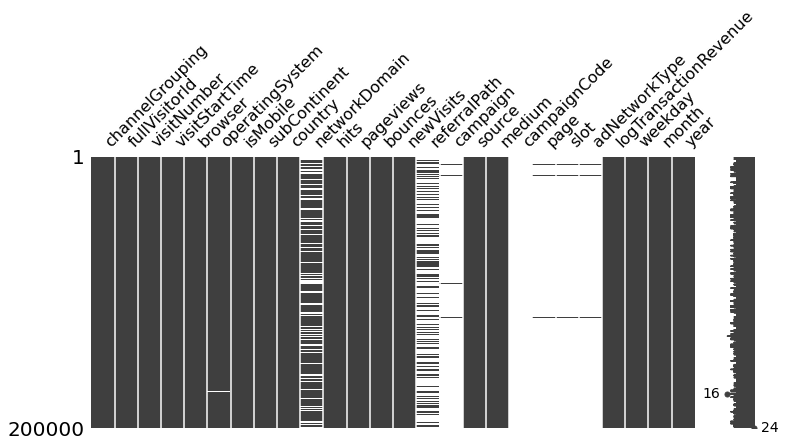

In [14]:
msno.matrix(training,figsize=(12,5))

## Outlier Removal

In [15]:
# Remove data greater than 3 std away from mean

print("before outlier removal, " + str(training.shape[0]) + " rows")

for col in numeric_cols:
    training[col] = training[col].astype(float)
    training = training[np.abs(training[col]-training[col].mean())<=(3*training[col].std())] 
    
print("after outlier removal, " + str(training.shape[0]) + " rows")

before outlier removal, 200000 rows
after outlier removal, 196124 rows


## Get Dummies & Bins

In [16]:
pd.get_dummies(training[cat_cols+['weekday','month','year']], drop_first=True)

,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Other,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,browser_Chrome,browser_Edge,browser_Firefox,browser_Internet Explorer,browser_Opera,browser_Opera Mini,browser_Other,browser_Safari,browser_Safari (in-app),browser_UC Browser,browser_YaBrowser,operatingSystem_Chrome OS,operatingSystem_Linux,operatingSystem_Macintosh,operatingSystem_Other,operatingSystem_Windows,operatingSystem_Windows Phone,operatingSystem_iOS,subContinent_Caribbean,subContinent_Central America,subContinent_Central Asia,subContinent_Eastern Africa,subContinent_Eastern Asia,subContinent_Eastern Europe,subContinent_Northern Africa,subContinent_Northern America,subContinent_Northern Europe,subContinent_Other,subContinent_South America,subContinent_Southeast Asia,subContinent_Southern Africa,subContinent_Southern Asia,subContinent_Southern Europe,subContinent_Western Africa,subContinent_Western Asia,subContinent_Western Europe,country_Argentina,country_Australia,country_Austria,country_Bangladesh,country_Belarus,country_Belgium,country_Brazil,country_Bulgaria,country_Canada,country_Chile,country_China,country_Colombia,country_Croatia,country_Czechia,country_Denmark,country_Dominican Republic,country_Ecuador,country_Egypt,country_Finland,country_France,country_Georgia,country_Germany,country_Greece,country_Hong Kong,country_Hungary,country_India,country_Indonesia,country_Ireland,country_Israel,country_Italy,country_Japan,country_Jordan,country_Kazakhstan,country_Malaysia,country_Mexico,country_Morocco,country_Netherlands,country_New Zealand,country_Nigeria,country_Norway,country_Other,country_Pakistan,country_Peru,country_Philippines,country_Poland,country_Portugal,country_Romania,country_Russia,country_Saudi Arabia,country_Serbia,country_Singapore,country_Slovakia,country_South Africa,country_South Korea,country_Spain,country_Sri Lanka,country_Sweden,country_Switzerland,country_Taiwan,country_Thailand,country_Tunisia,country_Turkey,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Venezuela,country_Vietnam,networkDomain_Other,networkDomain_actcorp.in,networkDomain_airtelbroadband.in,networkDomain_amazonaws.com,networkDomain_as13285.net,networkDomain_as9105.com,networkDomain_asianet.co.th,networkDomain_att.net,networkDomain_bbtec.net,networkDomain_bell.ca,networkDomain_bezeqint.net,networkDomain_bhn.net,networkDomain_bigpond.net.au,networkDomain_brasiltelecom.net.br,networkDomain_btcentralplus.com,networkDomain_cable.net.co,networkDomain_cantv.net,networkDomain_chello.pl,networkDomain_cogentco.com,networkDomain_com,networkDomain_comcast.net,networkDomain_comcastbusiness.net,networkDomain_cox.net,networkDomain_ctinets.com,networkDomain_fastwebnet.it,networkDomain_fibertel.com.ar,networkDomain_frontiernet.net,networkDomain_google.com,networkDomain_gvt.net.br,networkDomain_hinet.net,networkDomain_megared.net.mx,networkDomain_mycingular.net,networkDomain_myvzw.com,networkDomain_netvigator.com,networkDomain_ocn.ne.jp,networkDomain_ono.com,networkDomain_optonline.net,networkDomain_optusnet.com.au,networkDomain_pldt.net,networkDomain_prod-infinitum.com.mx,networkDomain_proxad.net,networkDomain_qwest.net,networkDomain_rcn.com,networkDomain_rdsnet.ro,networkDomain_rima-tde.net,networkDomain_rogers.com,networkDomain_rr.com,networkDomain_sbcglobal.net,networkDomain_sfr.net,networkDomain_shawcable.net,networkDomain_singnet.com.sg,networkDomain_spcsdns.net,networkDomain_suddenlink.net,networkDomain_superonline.net,networkDomain_t-ipconnect.de,networkDomain_tedata.net,networkDomain_telecomitalia.it,networkDomain_telefonica.de,networkDomain_telesp.net.br,networkDomain_telia.com,networkDomain_totbb.net,networkDomain_tpgi.com.au,networkDomain_tpnet.pl,networkDomain_ttnet.com.tr,networkDomain_ucom.ne.jp,networkDomain_unknown.unknown,networkDomain_vdc.vn,networkDomain_veloxzone.com.br,networkDomain_verizon.net,ne

In [17]:
training = training.join(pd.get_dummies(training[cat_cols+['weekday','month','year']], drop_first=True))

In [18]:
training = training[[col for col in training.columns if col not in list(set(cols_with_sparsity_issues+cat_cols+['weekday','month','year']))]]
training

,fullVisitorId,visitStartTime,isMobile,pageviews,bounces,newVisits,campaignCode,logTransactionRevenue,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Other,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,browser_Chrome,browser_Edge,browser_Firefox,browser_Internet Explorer,browser_Opera,browser_Opera Mini,browser_Other,browser_Safari,browser_Safari (in-app),browser_UC Browser,browser_YaBrowser,operatingSystem_Chrome OS,operatingSystem_Linux,operatingSystem_Macintosh,operatingSystem_Other,operatingSystem_Windows,operatingSystem_Windows Phone,operatingSystem_iOS,subContinent_Caribbean,subContinent_Central America,subContinent_Central Asia,subContinent_Eastern Africa,subContinent_Eastern Asia,subContinent_Eastern Europe,subContinent_Northern Africa,subContinent_Northern America,subContinent_Northern Europe,subContinent_Other,subContinent_South America,subContinent_Southeast Asia,subContinent_Southern Africa,subContinent_Southern Asia,subContinent_Southern Europe,subContinent_Western Africa,subContinent_Western Asia,subContinent_Western Europe,country_Argentina,country_Australia,country_Austria,country_Bangladesh,country_Belarus,country_Belgium,country_Brazil,country_Bulgaria,country_Canada,country_Chile,country_China,country_Colombia,country_Croatia,country_Czechia,country_Denmark,country_Dominican Republic,country_Ecuador,country_Egypt,country_Finland,country_France,country_Georgia,country_Germany,country_Greece,country_Hong Kong,country_Hungary,country_India,country_Indonesia,country_Ireland,country_Israel,country_Italy,country_Japan,country_Jordan,country_Kazakhstan,country_Malaysia,country_Mexico,country_Morocco,country_Netherlands,country_New Zealand,country_Nigeria,country_Norway,country_Other,country_Pakistan,country_Peru,country_Philippines,country_Poland,country_Portugal,country_Romania,country_Russia,country_Saudi Arabia,country_Serbia,country_Singapore,country_Slovakia,country_South Africa,country_South Korea,country_Spain,country_Sri Lanka,country_Sweden,country_Switzerland,country_Taiwan,country_Thailand,country_Tunisia,country_Turkey,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Venezuela,country_Vietnam,networkDomain_Other,networkDomain_actcorp.in,networkDomain_airtelbroadband.in,networkDomain_amazonaws.com,networkDomain_as13285.net,networkDomain_as9105.com,networkDomain_asianet.co.th,networkDomain_att.net,networkDomain_bbtec.net,networkDomain_bell.ca,networkDomain_bezeqint.net,networkDomain_bhn.net,networkDomain_bigpond.net.au,networkDomain_brasiltelecom.net.br,networkDomain_btcentralplus.com,networkDomain_cable.net.co,networkDomain_cantv.net,networkDomain_chello.pl,networkDomain_cogentco.com,networkDomain_com,networkDomain_comcast.net,networkDomain_comcastbusiness.net,networkDomain_cox.net,networkDomain_ctinets.com,networkDomain_fastwebnet.it,networkDomain_fibertel.com.ar,networkDomain_frontiernet.net,networkDomain_google.com,networkDomain_gvt.net.br,networkDomain_hinet.net,networkDomain_megared.net.mx,networkDomain_mycingular.net,networkDomain_myvzw.com,networkDomain_netvigator.com,networkDomain_ocn.ne.jp,networkDomain_ono.com,networkDomain_optonline.net,networkDomain_optusnet.com.au,networkDomain_pldt.net,networkDomain_prod-infinitum.com.mx,networkDomain_proxad.net,networkDomain_qwest.net,networkDomain_rcn.com,networkDomain_rdsnet.ro,networkDomain_rima-tde.net,networkDomain_rogers.com,networkDomain_rr.com,networkDomain_sbcglobal.net,networkDomain_sfr.net,networkDomain_shawcable.net,networkDomain_singnet.com.sg,networkDomain_spcsdns.net,networkDomain_suddenlink.net,networkDomain_superonline.net,networkDomain_t-ipconnect.de,networkDomain_tedata.net,networkDomain_telecomitalia.it,networkDomain_telefonica.de,networkDomain_telesp.net.br,networkDomain_telia.com,networkDomain_totbb.net,networkDomain_tpgi.com.au,networkDomain_tpnet.pl,networkDomain_ttnet.com.tr,networkDomain_ucom.ne.jp,networkDo

## Other individual column adjustments

In [19]:
training['isMobile'] = training['isMobile'].astype(int)
training = training.drop('visitStartTime', axis=1)
training

,fullVisitorId,isMobile,pageviews,bounces,newVisits,campaignCode,logTransactionRevenue,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Other,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,browser_Chrome,browser_Edge,browser_Firefox,browser_Internet Explorer,browser_Opera,browser_Opera Mini,browser_Other,browser_Safari,browser_Safari (in-app),browser_UC Browser,browser_YaBrowser,operatingSystem_Chrome OS,operatingSystem_Linux,operatingSystem_Macintosh,operatingSystem_Other,operatingSystem_Windows,operatingSystem_Windows Phone,operatingSystem_iOS,subContinent_Caribbean,subContinent_Central America,subContinent_Central Asia,subContinent_Eastern Africa,subContinent_Eastern Asia,subContinent_Eastern Europe,subContinent_Northern Africa,subContinent_Northern America,subContinent_Northern Europe,subContinent_Other,subContinent_South America,subContinent_Southeast Asia,subContinent_Southern Africa,subContinent_Southern Asia,subContinent_Southern Europe,subContinent_Western Africa,subContinent_Western Asia,subContinent_Western Europe,country_Argentina,country_Australia,country_Austria,country_Bangladesh,country_Belarus,country_Belgium,country_Brazil,country_Bulgaria,country_Canada,country_Chile,country_China,country_Colombia,country_Croatia,country_Czechia,country_Denmark,country_Dominican Republic,country_Ecuador,country_Egypt,country_Finland,country_France,country_Georgia,country_Germany,country_Greece,country_Hong Kong,country_Hungary,country_India,country_Indonesia,country_Ireland,country_Israel,country_Italy,country_Japan,country_Jordan,country_Kazakhstan,country_Malaysia,country_Mexico,country_Morocco,country_Netherlands,country_New Zealand,country_Nigeria,country_Norway,country_Other,country_Pakistan,country_Peru,country_Philippines,country_Poland,country_Portugal,country_Romania,country_Russia,country_Saudi Arabia,country_Serbia,country_Singapore,country_Slovakia,country_South Africa,country_South Korea,country_Spain,country_Sri Lanka,country_Sweden,country_Switzerland,country_Taiwan,country_Thailand,country_Tunisia,country_Turkey,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Venezuela,country_Vietnam,networkDomain_Other,networkDomain_actcorp.in,networkDomain_airtelbroadband.in,networkDomain_amazonaws.com,networkDomain_as13285.net,networkDomain_as9105.com,networkDomain_asianet.co.th,networkDomain_att.net,networkDomain_bbtec.net,networkDomain_bell.ca,networkDomain_bezeqint.net,networkDomain_bhn.net,networkDomain_bigpond.net.au,networkDomain_brasiltelecom.net.br,networkDomain_btcentralplus.com,networkDomain_cable.net.co,networkDomain_cantv.net,networkDomain_chello.pl,networkDomain_cogentco.com,networkDomain_com,networkDomain_comcast.net,networkDomain_comcastbusiness.net,networkDomain_cox.net,networkDomain_ctinets.com,networkDomain_fastwebnet.it,networkDomain_fibertel.com.ar,networkDomain_frontiernet.net,networkDomain_google.com,networkDomain_gvt.net.br,networkDomain_hinet.net,networkDomain_megared.net.mx,networkDomain_mycingular.net,networkDomain_myvzw.com,networkDomain_netvigator.com,networkDomain_ocn.ne.jp,networkDomain_ono.com,networkDomain_optonline.net,networkDomain_optusnet.com.au,networkDomain_pldt.net,networkDomain_prod-infinitum.com.mx,networkDomain_proxad.net,networkDomain_qwest.net,networkDomain_rcn.com,networkDomain_rdsnet.ro,networkDomain_rima-tde.net,networkDomain_rogers.com,networkDomain_rr.com,networkDomain_sbcglobal.net,networkDomain_sfr.net,networkDomain_shawcable.net,networkDomain_singnet.com.sg,networkDomain_spcsdns.net,networkDomain_suddenlink.net,networkDomain_superonline.net,networkDomain_t-ipconnect.de,networkDomain_tedata.net,networkDomain_telecomitalia.it,networkDomain_telefonica.de,networkDomain_telesp.net.br,networkDomain_telia.com,networkDomain_totbb.net,networkDomain_tpgi.com.au,networkDomain_tpnet.pl,networkDomain_ttnet.com.tr,networkDomain_ucom.ne.jp,networkDomain_unknown.un

## Numeric Feature Scaling - especially for SVM

In [20]:
# scaler = StandardScaler()
# training['humidity'] = scaler.fit_transform(training[['humidity']])
# training['atemp'] = scaler.fit_transform(training[['atemp']])

## Correlation Map

In [ ]:
corrMatt = training[[col for col in training if col!='fullVisitorId']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(50,20)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

## Degree Search - uneeded as we are using gradient boosting

In [ ]:
# df, degree_dict = degree_search(df=training[['atemp', 'temp', 'windspeed', 'humidity','count']], dep='count')

## Dependent & Independent Split

In [21]:
X = training[[col for col in training.columns if col not in dependent_var and col not in id_cols]]
y = training[dependent_var[0]]

## Polynomial Degree Search - uneeded as we are using gradient boosting

In [ ]:
# poly_dict = polynomial_search(X, y, highest_degree=2)
# poly_dict

## Generate Polynomial Features for Numeric Variables  - uneeded as we are using gradient boosting

In [ ]:
# poly = PolynomialFeatures(1)
# X = poly.fit_transform(X)

# X.shape

## Feature Selection - Variance Thresholding

In [22]:
sel = VarianceThreshold(threshold=(.91 * (1 - .91)))
X = sel.fit_transform(X)

ValueError: could not convert string to float: '11251kjhkvahf'

## Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=1)

## Linear Regression

In [ ]:
lreg = LinearRegression()
lreg.fit(X_train, y_train)

lreg.score(X_test, y_test)

predictions = lreg.predict(X_test)



txt1 = "Adjusted R squared: {AR}; \nRMSLE: {rmsle}".format(AR=lreg.score(X_test, y_test), 
                                                            rmsle=np.sqrt(mean_squared_log_error(y_test, np.maximum(predictions, 0))))
print(txt1)

## Support Vector Regression

In [ ]:
svreg = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
svreg.fit(X_train, y_train)

svreg.score(X_test, y_test)

predictions = svreg.predict(X_test)



txt1 = "Adjusted R squared: {AR}; \nRMSLE: {rmsle}".format(AR=svreg.score(X_test, y_test), 
                                                            rmsle=np.sqrt(mean_squared_log_error(y_test, np.maximum(predictions, 0))))
print(txt1)

## Random Forest Regressor

In [ ]:
rfreg = RandomForestRegressor(max_depth=2, random_state=0)
rfreg.fit(X_train, y_train)

rfreg.score(X_test, y_test)

predictions = rfreg.predict(X_test)



txt1 = "Adjusted R squared: {AR}; \nRMSLE: {rmsle}".format(AR=rfreg.score(X_test, y_test), 
                                                            rmsle=np.sqrt(mean_squared_log_error(y_test, np.maximum(predictions, 0))))
print(txt1)

## Hyperparameter Tuning

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Training with random_grid

rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)


ar = rf_random.score(X_test, y_test)

predictions = rf_random.predict(X_test)



txt1 = "Adjusted R squared: {AR}; \nRMSLE: {rmsle}".format(AR=ar, 
                                                            rmsle=np.sqrt(mean_squared_log_error(y_test, np.maximum(predictions, 0))))
print(txt1)

## Gradient Boosting Regressor

In [ ]:
gbreg = GradientBoostingRegressor(random_state=0)
gbreg.fit(X_train, y_train)

gbreg.score(X_test, y_test)

predictions = gbreg.predict(X_test)



txt1 = "Adjusted R squared: {AR}; \nRMSLE: {rmsle}".format(AR=gbreg.score(X_test, y_test), 
                                                            rmsle=np.sqrt(mean_squared_log_error(y_test, np.maximum(predictions, 0))))
print(txt1)

## Hyperparameter Tuning

In [ ]:
# Number of trees in gbm
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Training with random_grid

gb = GradientBoostingRegressor(random_state=0)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
gb_random.fit(X_train, y_train)


ar = gb_random.score(X_test, y_test)

predictions = gb_random.predict(X_test)



txt1 = "Adjusted R squared: {AR}; \nRMSLE: {rmsle}".format(AR=ar, 
                                                            rmsle=np.sqrt(mean_squared_log_error(y_test, np.maximum(predictions, 0))))
print(txt1)

## XGBoost

In [ ]:
train_data = xgb.DMatrix(X_train, y_train)
test_data = xgb.DMatrix(X_test, y_test)

params = {"booster": 'gbtree',
              "objective" : "reg:squaredlogerror",
              "eval_metric" : "auc", 
              "is_unbalance": True,
              "n_estimators": 500,
              "max_depth" : 5,
              "reg_alpha" : 0.01,
              "reg_lambda" : 0.01,
              "gamma": 5,
              "num_threads" : 20,
              "min_child_weight" : 5,
              "learning_rate" : 0.01,
              "subsample_freq" : 5,
              "seed" : 42,
              "verbosity" : 0,
              "num_boost_round": 500}



cv_result = xgb.cv(params,
                   train_data,
                   1000,
                   early_stopping_rounds=100,
                   stratified=True,
                   nfold=3)

xgboost = xgb.train(params, train_data, 10000)

predictions = xgboost.predict(test_data)

ar = r2_score(y_test,np.maximum(predictions, 0))




txt1 = "Adjusted R squared: {AR}; \nRMSLE: {rmsle}".format(AR=ar, 
                                                            rmsle=np.sqrt(mean_squared_log_error(y_test, np.maximum(predictions, 0))))
print(txt1)

## Save Best Model

In [ ]:
dump(gbreg, 'Models/GradientBoosting.joblib') 

## Generate Kaggle Predictions

In [ ]:
test_data = pd.read_csv('Data/test.csv')



test_data["date"] = test_data.datetime.apply(lambda x : x.split()[0])
test_data["hour"] = test_data.datetime.apply(lambda x : x.split()[1].split(":")[0])
test_data["weekday"] = test_data.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
test_data["month"] = test_data.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])


# Mapping to strings
test_data["season"] = test_data.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
test_data["weather"] = test_data.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })





# Mapping to categories

categoryVariables = ["season","weather", "weekday"]
textCategories = ["season","weather", "weekday"]
alreadyCategories = ["holiday", "workingday"]
binVariables = ["hour"]


for var in categoryVariables:
    test_data[var] = test_data[var].astype("category")
    
    
    
# Unrepeatable
bins = KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='uniform')
test_data[binVariables] = bins.fit_transform(test_data[binVariables])
test_data[binVariables] = test_data[binVariables].astype("category")


dummie_cols = pd.get_dummies(test_data[textCategories+binVariables]).columns
test_data = test_data.join(pd.get_dummies(test_data[textCategories+binVariables]))

X = test_data[numericVariables+list(dummie_cols)+alreadyCategories]


X = poly.transform(X)
X = sel.transform(X)

test_data['count'] = rf_random.predict(X)

test_data.to_csv('Data/test_labelled.csv')

In [ ]:
test_data[['datetime', 'count']].to_csv('Data/test_submission.csv', index=False)

In [ ]:
test_data[['datetime', 'count']]